# Tube Twin: Passenger count forecasting/general tube analysis 

© Explore Data Science Academy

## Introduction 

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="../Assets/LU_Baker-street.jpg" 
     alt="London Underground"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. The London Tube</em></p> 
</div>

**Client**: Transport for London (TfL) 

Transport for London runs the London Underground (aka “The Tube”), which is a network of train stations which connects the city of London.

**Team**: 

This is Team 6. A combination of data scientists and data engineers that have been assigned the Tube Twin project and this is a notebook for executing various aspect of the project workflow. 

## Context

This project's objective is to create a digital twin of the london tube that can be used for passenger count and traffic analyses/forecasting.


## Import libraries
Below we import the libraries required to complete this section of the predict.

In [1]:
import findspark
findspark.init()
findspark.find()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import * 

> ℹ️ **Objective** ℹ️
>
>Initialise a new **Spark Context** and **Session** for interfacing with Spark.

In [3]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc) 

## Parquet files
In the previous section of the predict, you generated parquet files to your local directory. You will be making use of these files to continue with this section of the predict. Please make sure that your parquet files are specifically for the year **1962**. Any other year used outside of **1962** will produce incorrect answers and have a negative impact on your overall predict mark.

> ℹ️ **Instructions** ℹ️
>
> Read the parquet files stored in your directory for the year **1962** into a Spark DataFrame.

In [4]:
parquet_file_path = r'../Data/data_ingestion.parquet' 
df = spark.read.parquet(parquet_file_path, engine='auto') 

df.show(1) 

df.printSchema() 

+----+---+----+----------+--------------------+-------------------+---+---+------+-----+-------+----------+-------+-------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Instructions** ℹ️
>
> Generate summary statistics to explore your data. Make sure you understand the ranges, means, extremums, and deviations found in the data set.

In [5]:
df.summary().toPandas() 

,summary,mode,nlc,asc,station,coverage,day,dir,total,early,...,0230-0245,0245-0300,0300-0315,0315-0330,0330-0345,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500
0,count,17458,17458,17458,17458,17426,17458,17458,17458,17458,...,17458,17458,17458,17458,17458,17458,17458,17458,17458,17458
1,mean,None,1852.8311375873525,None,None,None,None,None,7775.084349474883,233.7227949993955,...,1.9423187077557567,1.7743727803872151,1.7268301065414138,1.579161415969756,1.472104479321801,1.280100813380685,1.2375988085691374,1.0241150189025088,1.078293438024498,1.3625567523147573
2,stddev,None,2424.44910158847,None,None,None,None,None,13769.647893261645,468.22794749453533,...,13.111663927029532,12.109944524839134,12.207975715277005,11.520009065235147,10.227679385395252,8.398657775338465,7.863147646917768,6.263068928113061,5.715258852086833,5.665110255652002
3,min,DLR,500,ABRd,Abbey Road,DLR boarding / alighting,FRI,IN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25%,None,608,None,None,None,None,None,1611.0,23.8875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,50%,None,719,None,None,None,None,None,3491.0,80.53333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,75%,None,1083,None,None,None,None,None,7756.4,231.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08580104
7,max,TfLRail,9846,WWRr,Woolwich Arsenal,Trams boarding / alighting,SUN,OUT,157088.0,7104.0,...,406.0,393.0,427.0,447.0,369.0,291.0,242.0,189.0,129.0,108.0


> ℹ️ **Instructions** ℹ️
>
> Generate histograms for the six numerical attributes found in the data to understand the distribution of values.
>
>*You may use as many coding cells as necessary.*

In [15]:
todd_distr = df.select('early', 'am_peak', 'inter_peak', 'pm_peak', 'evening', 'late') 
todd_df = todd_distr.toPandas() 

todd_df.head(3) 

todd_total = df.select('total', 'early', 'am_peak', 'inter_peak', 'pm_peak', 'evening', 'late') 
todd_tl_df = todd_total.toPandas() 

todd_tl_df.head(3) 

,total,early,am_peak,inter_peak,pm_peak,evening,late
0,3701.899902,288.200012,1101.199951,1185.699951,824.200012,213.199997,89.400002
1,2489.416748,172.583328,520.166687,622.000000,920.000000,208.416672,46.250000
2,3198.307617,103.000000,472.692322,1063.923096,1126.461548,333.230774,99.000000


array([[<AxesSubplot:title={'center':'early'}>,
        <AxesSubplot:title={'center':'am_peak'}>],
       [<AxesSubplot:title={'center':'inter_peak'}>,
        <AxesSubplot:title={'center':'pm_peak'}>],
       [<AxesSubplot:title={'center':'evening'}>,
        <AxesSubplot:title={'center':'late'}>]], dtype=object)

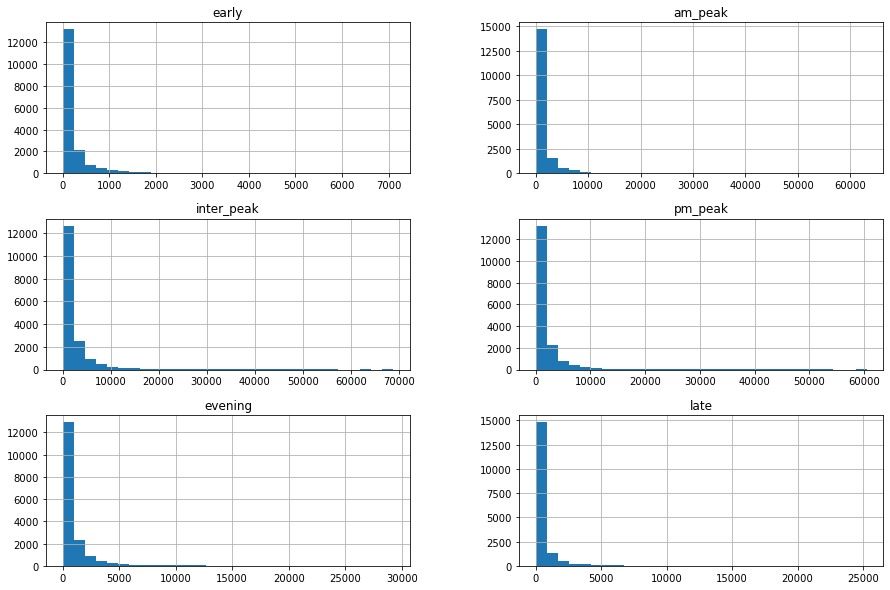

In [9]:
# Histogram View
todd_df.hist(bins=30, figsize=(15, 10)) 

<AxesSubplot:>

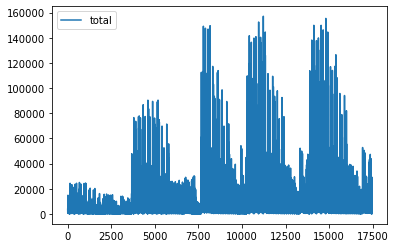

In [16]:
todd_tl_df.plot.line(y='total', use_index=True) 

> ℹ️ **Instructions** ℹ️
>
> Investigate the **open** column to identify stocks that have open values greater than 2, and note any anomalies that you find in the data.
>
>*You may use as many coding cells as necessary.*

In [13]:
#TODO: Write your code here 
df.where(F.col('open')> 2).orderBy(F.col('stock')).show(10) 

+-------------------+--------+--------+--------+--------+---------+-------+-----+
|               date|    open|    high|     low|   close|adj_close| volume|stock|
+-------------------+--------+--------+--------+--------+---------+-------+-----+
|1962-07-09 00:00:00| 5.64705|5.707125|5.538915|5.707125| 1.356625|86500.0|   AA|
|1962-06-21 00:00:00| 5.03829| 5.03829|4.938165|4.946175|1.1757424|66500.0|   AA|
|1962-07-17 00:00:00|5.562945|5.562945| 5.40675| 5.40675|1.2852237|24500.0|   AA|
|1962-06-15 00:00:00| 5.05431| 5.23854| 5.02227|  5.2065|1.2376224|96500.0|   AA|
|1962-08-16 00:00:00|6.331905|   6.408|6.331905|6.363945|1.5203078|58500.0|   AA|
|1962-06-18 00:00:00|  5.2065| 5.25456|5.122395| 5.25456|1.2490451|67900.0|   AA|
|1962-06-22 00:00:00|4.906125|4.906125|4.721895|4.729905|1.1243328|42500.0|   AA|
|1962-12-19 00:00:00|5.122395|5.338665|5.122395|5.306625|1.2748827|65900.0|   AA|
|1962-08-29 00:00:00|5.939415|5.939415| 5.85531|5.939415|1.4188904|35900.0|   AA|
|1962-12-27 00:0

In [11]:
df.filter(df.open>2).groupBy(df.stock).count().show() 

+-----+-----+
|stock|count|
+-----+-----+
|   AA|  252|
|ARNCA|   21|
|   PG|   23|
|  IBM|  252|
| ARNC|  231|
+-----+-----+



 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1.
 2.
    ...
 

> ℹ️ **Instructions** ℹ️
>
> Investigate **high**, **low**, **close**, and **adj_close** to determine if any stocks may be deviating from the normal ranges of the data set. Note down the stock(s) that you come across.
>
>*You may use as many coding cells as necessary.*

In [15]:
#TODO: Write your code here 
# Investigating for 'high' 
df.filter(df.high>53).orderBy(df.stock).show(10) 

df.filter(df.high>53).groupBy(df.stock).count().show() 

+-------------------+----+-------+-------+-------+----------+------+-----+
|               date|open|   high|    low|  close| adj_close|volume|stock|
+-------------------+----+-------+-------+-------+----------+------+-----+
|1962-12-19 00:00:00| 0.0|  240.0|   null|  240.0|112.589325| 700.0|  NAV|
|1962-01-12 00:00:00| 0.0|264.375|  260.0|264.375|118.235344|1300.0|  NAV|
|1962-06-18 00:00:00| 0.0|  242.5| 233.75| 233.75|106.930336| 900.0|  NAV|
|1962-07-03 00:00:00| 0.0|239.375|235.625| 236.25|108.073975|1600.0|  NAV|
|1962-08-13 00:00:00| 0.0|231.875|  230.0|230.625|105.500786|1300.0|  NAV|
|1962-11-12 00:00:00| 0.0|244.375| 236.25|244.375| 113.25212| 700.0|  NAV|
|1962-12-27 00:00:00| 0.0|248.125|   null|248.125| 116.40094| 600.0|  NAV|
|1962-03-15 00:00:00| 0.0| 278.75|276.875| 278.75| 126.00829|1200.0|  NAV|
|1962-04-26 00:00:00| 0.0| 268.75|  265.0|  265.0| 119.79269| 200.0|  NAV|
|1962-06-15 00:00:00| 0.0| 241.25|233.125|  240.0| 109.78941|1300.0|  NAV|
+-------------------+----

In [17]:
# Investigating for 'low' 
df.filter(df.low>51).orderBy(df.stock).show(10) 

df.filter(df.low>51).groupBy(df.stock).count().show() 

+-------------------+----+-------+-------+-------+----------+------+-----+
|               date|open|   high|    low|  close| adj_close|volume|stock|
+-------------------+----+-------+-------+-------+----------+------+-----+
|1962-02-19 00:00:00| 0.0|  280.0|276.875|279.375| 124.94374| 600.0|  NAV|
|1962-02-14 00:00:00| 0.0|276.875|273.125| 273.75| 122.42809| 800.0|  NAV|
|1962-02-13 00:00:00| 0.0|  277.5|  275.0| 276.25| 123.54612|1000.0|  NAV|
|1962-02-26 00:00:00| 0.0|279.375| 276.25|279.375| 124.94374| 700.0|  NAV|
|1962-02-06 00:00:00| 0.0|271.875|268.125| 271.25| 121.31004|1600.0|  NAV|
|1962-02-02 00:00:00| 0.0| 266.25| 263.75| 266.25|119.073845| 800.0|  NAV|
|1962-02-16 00:00:00| 0.0|  277.5|274.375|  277.5| 124.10516|1400.0|  NAV|
|1962-02-27 00:00:00| 0.0|  280.0| 278.75|  280.0|  125.2233| 600.0|  NAV|
|1962-02-12 00:00:00| 0.0| 276.25|274.375| 276.25| 123.54612| 700.0|  NAV|
|1962-02-20 00:00:00| 0.0|  280.0|276.875|279.375| 124.94374|1000.0|  NAV|
+-------------------+----

In [18]:
# Investigating for 'close' 
df.filter(df.close>53).orderBy(df.stock).show(10) 

df.filter(df.close>53).groupBy(df.stock).count().show() 

+-------------------+----+-------+-------+-------+----------+------+-----+
|               date|open|   high|    low|  close| adj_close|volume|stock|
+-------------------+----+-------+-------+-------+----------+------+-----+
|1962-12-19 00:00:00| 0.0|  240.0|   null|  240.0|112.589325| 700.0|  NAV|
|1962-01-12 00:00:00| 0.0|264.375|  260.0|264.375|118.235344|1300.0|  NAV|
|1962-06-18 00:00:00| 0.0|  242.5| 233.75| 233.75|106.930336| 900.0|  NAV|
|1962-07-03 00:00:00| 0.0|239.375|235.625| 236.25|108.073975|1600.0|  NAV|
|1962-08-13 00:00:00| 0.0|231.875|  230.0|230.625|105.500786|1300.0|  NAV|
|1962-11-12 00:00:00| 0.0|244.375| 236.25|244.375| 113.25212| 700.0|  NAV|
|1962-12-27 00:00:00| 0.0|248.125|   null|248.125| 116.40094| 600.0|  NAV|
|1962-03-15 00:00:00| 0.0| 278.75|276.875| 278.75| 126.00829|1200.0|  NAV|
|1962-04-26 00:00:00| 0.0| 268.75|  265.0|  265.0| 119.79269| 200.0|  NAV|
|1962-06-15 00:00:00| 0.0| 241.25|233.125|  240.0| 109.78941|1300.0|  NAV|
+-------------------+----

In [19]:
# Investigating for 'adj_close' 
df.filter(df.adj_close>24).orderBy(df.stock).show(10) 

df.filter(df.adj_close>24).groupBy(df.stock).count().show() 

+-------------------+----+-------+-------+-------+----------+------+-----+
|               date|open|   high|    low|  close| adj_close|volume|stock|
+-------------------+----+-------+-------+-------+----------+------+-----+
|1962-02-19 00:00:00| 0.0|  280.0|276.875|279.375| 124.94374| 600.0|  NAV|
|1962-02-14 00:00:00| 0.0|276.875|273.125| 273.75| 122.42809| 800.0|  NAV|
|1962-02-13 00:00:00| 0.0|  277.5|  275.0| 276.25| 123.54612|1000.0|  NAV|
|1962-02-26 00:00:00| 0.0|279.375| 276.25|279.375| 124.94374| 700.0|  NAV|
|1962-02-06 00:00:00| 0.0|271.875|268.125| 271.25| 121.31004|1600.0|  NAV|
|1962-02-02 00:00:00| 0.0| 266.25| 263.75| 266.25|119.073845| 800.0|  NAV|
|1962-02-16 00:00:00| 0.0|  277.5|274.375|  277.5| 124.10516|1400.0|  NAV|
|1962-02-27 00:00:00| 0.0|  280.0| 278.75|  280.0|  125.2233| 600.0|  NAV|
|1962-02-12 00:00:00| 0.0| 276.25|274.375| 276.25| 123.54612| 700.0|  NAV|
|1962-02-20 00:00:00| 0.0|  280.0|276.875|279.375| 124.94374|1000.0|  NAV|
+-------------------+----

 ## 📔️**Notes** 📔️

 *Use this cell to note down any potential findings.*

 1.
 2.
    ...



## Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

Completeness issues can occur at the row level (gaps within the dataset) or the field level (one entry missing). At the field level, entire fields can being empty, or >80% of a field's data missing. 

Another issue that may occur is default values. A typical example of this is where a logger sends back a 0 instead of a null value, which can greatly skew any attempts at modelling. This is where it is instrumental to employ domain knowledge when assessing a dataset. 

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy.

### Missing values

> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of missing values (nulls) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_missing_values> (<percentage>) null values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [21]:
#TODO: Write your code here 
missing_vals = {}  # Dictionary to keep track of the results

for column in df.columns:   #Loop through each column in df 
    ncount = df.where(df[column].isNull()).count()  #Null count in column x
    tcount = df.select(df[column]).count()    #Total count of column x 
    print(f'There are {ncount} ({round(ncount/tcount*100, 2)}%) null values in {column} column') 
    missing_vals[f'{column}'] = ncount #Recording results in missing_count dictionary 

There are 0 (0.0%) null values in date column
There are 0 (0.0%) null values in open column
There are 0 (0.0%) null values in high column
There are 42 (0.82%) null values in low column
There are 0 (0.0%) null values in close column
There are 21 (0.41%) null values in adj_close column
There are 21 (0.41%) null values in volume column
There are 0 (0.0%) null values in stock column


### Columns with missing values


> ℹ️ **Instructions** ℹ️
>
> From the above result, probe the columns that are affected by the missing data to find out which stocks were affected.
>
>*You may use as many coding cells as necessary.*

In [30]:
#TODO: Write your code here 
df.filter(df.low.isNull() | df.adj_close.isNull() | df.volume.isNull()).orderBy(df.stock).show(10) 

df.filter(df.low.isNull() | df.adj_close.isNull() | df.volume.isNull()).groupBy(df.stock).count().show() 

+-------------------+---------+---------+----+---------+----------+--------+-----+
|               date|     open|     high| low|    close| adj_close|  volume|stock|
+-------------------+---------+---------+----+---------+----------+--------+-----+
|1962-03-16 00:00:00|1.6458334|1.6614584|null|1.6614584|0.14271663| 79200.0|  CAT|
|1962-03-09 00:00:00| 1.640625|1.6458334|null|1.6354166|0.14047968| 86400.0|  CAT|
|1962-03-30 00:00:00|1.6822916| 1.703125|null| 1.703125|0.14629564| 86400.0|  CAT|
|1962-03-15 00:00:00|1.6614584|1.6614584|null|1.6458334|0.14137442|139200.0|  CAT|
|1962-03-07 00:00:00|1.6770834|1.6770834|null|  1.65625| 0.1422691|172800.0|  CAT|
|1962-03-01 00:00:00|1.6822916| 1.703125|null|1.6822916|0.14450607| 74400.0|  CAT|
|1962-03-23 00:00:00|1.6822916|1.6979166|null|1.6822916|0.14450607|189600.0|  CAT|
|1962-03-02 00:00:00|1.6822916|   1.6875|null|   1.6875|0.14495347|105600.0|  CAT|
|1962-03-28 00:00:00| 1.671875| 1.703125|null| 1.703125|0.14629564|146400.0|  CAT|
|196

#### Fix Completeness

How do we deal with incomplete data?
- Dropping missing values
- Discard the incomplete column
- Discard the rows containing missing data
- Case deletion

> ℹ️ **Instructions** ℹ️
>
> Use the appropriate strategy to remedy the missing data. 
>
>*You may use as many coding cells as necessary.*

In [31]:
#TODO: Write your code here 
df = df.na.drop() 

for column in ['low', 'adj_close', 'volume']: 
    print(f'Missing values in {column}:') 
    df.select('stock', column).filter(df[column].isNull()).groupBy('stock').count().show() 

Missing values in low:
+-----+-----+
|stock|count|
+-----+-----+
+-----+-----+

Missing values in adj_close:
+-----+-----+
|stock|count|
+-----+-----+
+-----+-----+

Missing values in volume:
+-----+-----+
|stock|count|
+-----+-----+
+-----+-----+



In [33]:
df.groupBy(df.stock).count().show(10) 

+-----+-----+
|stock|count|
+-----+-----+
|   AA|  252|
|  XOM|  252|
|  DIS|  252|
|ARNCA|   21|
|   PG|  252|
|   GT|  252|
|   MO|  252|
|  IBM|  252|
|  JNJ|  231|
|  CVX|  252|
+-----+-----+
only showing top 10 rows



### Zero Values

Take a deeper look into the entries with many zero values.

#### Fix Completeness

Completeness issues can be fixed through imputation of the missing data through:
- imputation by mean/mode/median;
- regression; or
- KNN.
 
> ℹ️ **Instructions** ℹ️
>
> Write code to identify and count the number of zeros (0) in the dataset. Include a percentage to describe the proportion of missing values per column. Output the results in the following manner:
>
> `There are <number_of_zeros> (<percentage>) zero values in <column_name> column`
>
>*You may use as many coding cells as necessary.*

In [35]:
#TODO: Write your code here 
cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume',] 

for col in cols: 
  zcount = df.where(df[col]==0).count() 
  t_count = df.select(df[col]).count() 
  print(f"The are {zcount} ({round(zcount/t_count*100, 3)}%) zero values in {col} column ") 

The are 2706 (53.883%) zero values in open column 
The are 20 (0.398%) zero values in high column 
The are 0 (0.0%) zero values in low column 
The are 0 (0.0%) zero values in close column 
The are 0 (0.0%) zero values in adj_close column 
The are 27 (0.538%) zero values in volume column 


From the above section, you find that there are a few columns that contain zero values. However, some of these are true zeros and are explainable. Your task is to distinguish which column should undergo data imputation.

> ℹ️ **Instructions** ℹ️
>
> Investigate the columns with zero values and determine which one should undergo data imputation. Take note of the stock and month on which zero values occurred.
>
>*You may use as many coding cells as necessary.*

In [36]:
#TODO: Write your code here 
df.filter(df.high == 0).orderBy(df.stock).show(10) 

df.filter(df.high == 0).groupBy(df.stock).count().show() 

+-------------------+---------+----+---------+---------+----------+--------+-----+
|               date|     open|high|      low|    close| adj_close|  volume|stock|
+-------------------+---------+----+---------+---------+----------+--------+-----+
|1962-11-05 00:00:00|1.4114584| 0.0|1.4114584|   1.4375|0.12620474|172800.0|  CAT|
|1962-11-12 00:00:00| 1.453125| 0.0|1.4427084|1.4583334|0.12803373| 96000.0|  CAT|
|1962-11-08 00:00:00|1.4583334| 0.0|1.4427084|1.4583334|0.12803373|129600.0|  CAT|
|1962-11-01 00:00:00|1.3697916| 0.0|1.3697916|1.4010416| 0.1230039|136800.0|  CAT|
|1962-11-29 00:00:00|1.5052084| 0.0|1.5052084|1.5052084|0.13214913|132000.0|  CAT|
|1962-11-28 00:00:00|      1.5| 0.0|1.4947916|1.5052084|0.13214913|177600.0|  CAT|
|1962-11-30 00:00:00|1.5052084| 0.0|1.5052084|1.5052084|0.13214913|124800.0|  CAT|
|1962-11-26 00:00:00|      1.5| 0.0|1.4947916|      1.5|0.13169187|187200.0|  CAT|
|1962-11-02 00:00:00|1.4010416| 0.0|1.3958334|1.4114584|0.12391846|211200.0|  CAT|
|196

In [38]:
df.filter(df.volume == 0).orderBy(df.stock).show(10) 

df.filter(df.volume == 0).groupBy(df.stock).count().show() 

+-------------------+----------+----------+----------+----------+------------+------+-----+
|               date|      open|      high|       low|     close|   adj_close|volume|stock|
+-------------------+----------+----------+----------+----------+------------+------+-----+
|1962-11-09 00:00:00|0.69736576|0.69736576|0.69736576|0.69736576|0.0016955283|   0.0|   GE|
|1962-04-17 00:00:00|       0.0|   0.21875| 0.2175926|   0.21875|6.1658733E-7|   0.0|  JNJ|
|1962-09-28 00:00:00|       0.0|0.15914352| 0.1574074|0.15914352| 4.514184E-7|   0.0|  JNJ|
|1962-10-15 00:00:00|       0.0|0.15856482|0.15856482|0.15856482|4.4977733E-7|   0.0|  JNJ|
|1962-01-02 00:00:00|       0.0|0.22337963|0.22222222|0.22337963| 6.281419E-7|   0.0|  JNJ|
|1962-05-09 00:00:00|       0.0| 1.6953125| 1.6796875|    1.6875| 0.015208395|   0.0|  XOM|
|1962-05-22 00:00:00|       0.0| 1.6601562| 1.6289062|  1.640625| 0.014785934|   0.0|  XOM|
|1962-05-04 00:00:00|       0.0| 1.7226562| 1.7109375|   1.71875|0.0153206745|  

In [42]:
df.filter(df.open == 0).orderBy(df.stock).show(10) 

df.filter(df.open == 0).groupBy(df.stock).count().show(5) 

+-------------------+----+---------+----+---------+-----------+--------+-----+
|               date|open|     high| low|    close|  adj_close|  volume|stock|
+-------------------+----+---------+----+---------+-----------+--------+-----+
|1962-02-02 00:00:00| 0.0| 3.452381|20.0| 3.452381|0.054961324|508800.0|  CVX|
|1962-02-09 00:00:00| 0.0| 3.482143|20.0|3.4747024|0.055316698|158400.0|  CVX|
|1962-02-19 00:00:00| 0.0| 3.578869|20.0| 3.549107|0.056501225|273600.0|  CVX|
|1962-02-26 00:00:00| 0.0|3.5193453|20.0| 3.482143|0.055435114|158400.0|  CVX|
|1962-02-06 00:00:00| 0.0|3.3854167|20.0|3.3630953|0.053539913|145600.0|  CVX|
|1962-02-14 00:00:00| 0.0|3.4970238|20.0|3.4970238|0.055672023|116800.0|  CVX|
|1962-02-13 00:00:00| 0.0|3.5044644|20.0|3.5044644|0.055790514|240000.0|  CVX|
|1962-02-16 00:00:00| 0.0| 3.549107|20.0|3.5416667|0.056382727|155200.0|  CVX|
|1962-02-27 00:00:00| 0.0|3.5119047|20.0|3.5119047| 0.05590893|294400.0|  CVX|
|1962-02-12 00:00:00| 0.0|3.5267856|20.0|3.5119047| 

> ℹ️ **Instructions** ℹ️
>
> Once you have identified the column that needs to undergo imputation, update the values for the affected records by using the average value for the affected stock.
>
>*You may use as many coding cells as necessary.*

In [43]:
#TODO: Write your code here 
df = df.withColumn('open',F.when(F.col('open')==0, df.agg(F.avg('open')).collect()[0][0]).otherwise(F.col('open'))) 

df.where(df.open == 0).count() 

0

In [44]:
df = df.withColumn('high',F.when(F.col('high')==0, df.agg(F.avg('high')).collect()[0][0]).otherwise(F.col('high'))) 

df.where(df.high == 0).count() 

0


## Consistency

Consistency is the absence of difference when comparing two or more representations of a thing against a reference.

Data entries that refer to the same record or entity have to be consistent across all entries, e.g., if you are dealing with records from a logger in the field, the entries for that logger have to remain consistent, and the name or primary key of that logger cannot change from one entry to another. 

For example, 'Logger1', 'Loger1' and 'Logge1' are examples of inconsistent keys. 

This is not just within a single table but also becomes more important if you are dealing with relational data. In which case, the mappings between tables and systems must be consistent. If not, the relationships will be completely lost between the tables and referential integrity compromised. 

- **Measured by**: Analysis of pattern and/or value frequency;
- **Units**: Percentage;
- **Related to**: Accuracy, Validity, and Uniqueness.

> ℹ️ **Instructions** ℹ️
>
> There currently exists a stock that has inconsistent naming. Make use of the metadata to determine which stock is inconsistently named, then update the dataframe appropriately to get rid of this inconsistency.
>
>*You may use as many coding cells as necessary.*

In [47]:
#TODO: Write your code here 
list(set(df.select('stock').rdd.flatMap(lambda x: x).collect())-set(meta.select('symbol').rdd.flatMap(lambda x: x).collect())) 

['ARNCA']

In [48]:
df.where(df.stock == 'ARNCA').count() 

21

In [49]:
#checking the correct name for the stock
meta.createOrReplaceTempView("metadata") 

spark.sql("select * from metadata where symbol like 'ARN%'").toPandas() 

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,ARNA,"Arena Pharmaceuticals, Inc. - Common Stock",Q,Q,N,100.0,N,N,None,ARNA,N
1,Y,ARNC,Arconic Corporation Common Stock,N,,N,100.0,N,None,ARNC,ARNC,N


In [50]:
#Replacing the stock with the correct name 
df = df.withColumn('stock', F.when(F.col('stock')=='ARNCA', 'ARNC').otherwise(F.col("stock"))) 

df.filter(df.stock == 'ARNC').groupBy(df.stock).count().show() 

+-----+-----+
|stock|count|
+-----+-----+
| ARNC|  252|
+-----+-----+



## Timeliness

Timeliness is the degree to which data represent reality from the required point in time.

Timeliness expects that the data within your dataset is sufficiently up to date. If you are trying to answer questions that relate to recent problems, having timely data is extremely important. For example, you cannot use current flight patterns to model how many aeroplanes will be required by a large aeronautics company within the next 5-10 years. 

Similarly, when answering questions that require real-time answers (e.g., predicting when a pipe will burst in a manufacturing plant), you have to be set up to receive real-time data from sensors and loggers. 

- **Measured by**: Time difference;
- **Units**: Time;
- **Related to**: Accuracy because it will decay as time progress. 

It is important to see the latest value for each of the stocks that we are looking at:

In [44]:
df.groupBy('stock').agg(F.max('Date')).show() 

+-----+----------+
|stock| max(Date)|
+-----+----------+
|   AA|1962-12-31|
|  XOM|1962-12-31|
|  DIS|1962-12-31|
|   PG|1962-12-31|
|   GT|1962-12-31|
|   MO|1962-12-31|
|  IBM|1962-12-31|
|  JNJ|1962-12-31|
|  CVX|1962-12-31|
|  DTE|1962-12-31|
|   BA|1962-12-31|
|   GE|1962-12-31|
|  HPQ|1962-12-31|
| ARNC|1962-12-31|
|  CAT|1962-12-31|
|   IP|1962-12-31|
|   FL|1962-12-31|
|   ED|1962-12-31|
|  NAV|1962-12-31|
|   KO|1962-12-31|
+-----+----------+



Sometimes, some of these axes of data quality will be less important than others. 
This is one of those cases where it is less important to have timely data, since 
we are trying to create a training dataset for a stock market prediction algorithm. 

It is important to know the context in which you are doing your modelling. 

### Gaps in the dataset

Let's see if we can find inconsistencies in the time series by having a look at the number of entries for each of the tickers.
 
> ℹ️ **Instructions** ℹ️
>
> Uncomment and use the below code to determine which dates had entries that were not equal to 20. You may have to change the name of the dataframe to see the resultant output
>
>*You may use as many coding cells as necessary.*

In [51]:
df.orderBy('date').groupby('date').count().where(F.col('count') != 20).show(400) 

+-------------------+-----+
|               date|count|
+-------------------+-----+
|1962-02-19 00:00:00|   23|
|1962-02-26 00:00:00|   23|
|1962-06-07 00:00:00|   19|
|1962-09-05 00:00:00|   21|
|1962-02-23 00:00:00|   23|
|1962-09-14 00:00:00|   21|
|1962-02-07 00:00:00|   23|
|1962-06-12 00:00:00|   19|
|1962-03-19 00:00:00|   19|
|1962-09-24 00:00:00|   21|
|1962-02-12 00:00:00|   23|
|1962-02-20 00:00:00|   23|
|1962-02-02 00:00:00|   23|
|1962-07-25 00:00:00|   19|
|1962-03-14 00:00:00|   19|
|1962-09-18 00:00:00|   21|
|1962-09-12 00:00:00|   21|
|1962-12-18 00:00:00|   19|
|1962-12-20 00:00:00|   19|
|1962-09-20 00:00:00|   21|
|1962-03-22 00:00:00|   19|
|1962-09-28 00:00:00|   21|
|1962-12-21 00:00:00|   19|
|1962-09-04 00:00:00|   21|
|1962-09-21 00:00:00|   21|
|1962-12-03 00:00:00|   19|
|1962-03-20 00:00:00|   19|
|1962-09-11 00:00:00|   21|
|1962-02-05 00:00:00|   23|
|1962-09-25 00:00:00|   21|
|1962-09-06 00:00:00|   21|
|1962-02-13 00:00:00|   23|
|1962-02-21 00:00:00

> ℹ️ **Instructions** ℹ️
>
> From the above result, investigate the number of times a stock appears for the given month. You can infer the months by using the output of the previous cell.
>
>*You may use as many coding cells as necessary.*

In [52]:
#TODO: Write your code here 
df.groupby(F.month('date'),'stock').count().orderBy('month(date)').show(400) 

+-----------+-----+-----+
|month(date)|stock|count|
+-----------+-----+-----+
|          1|   GE|   22|
|          1|   ED|   22|
|          1|  XOM|   22|
|          1|  DTE|   22|
|          1|   KO|   22|
|          1|   BA|   22|
|          1| ARNC|   22|
|          1|  JNJ|   22|
|          1|  CAT|   22|
|          1|   MO|   22|
|          1|   GT|   22|
|          1|   FL|   22|
|          1|  NAV|   22|
|          1|  IBM|   22|
|          1|  CVX|   22|
|          1|   PG|   22|
|          1|   IP|   22|
|          1|  DIS|   22|
|          1|  HPQ|   22|
|          1|   AA|   22|
|          2|   GE|   19|
|          2|  DTE|   19|
|          2|   BA|   19|
|          2|   GT|   19|
|          2|   IP|   19|
|          2|   FL|   19|
|          2|  CVX|   19|
|          2|  HPQ|   76|
|          2|  XOM|   19|
|          2| ARNC|   19|
|          2|   ED|   19|
|          2|   KO|   19|
|          2|  NAV|   19|
|          2|  DIS|   19|
|          2|   PG|   19|
|          2

## Uniqueness

Uniqueness requires that nothing will be recorded more than once based upon how that thing is identified. It is the inverse of an assessment of the level of duplication.

Each entry within the dataset should only relate to a single event that has occurred and thus should not be duplicated. This is largely mediated by having the appropriate primary key, which means sticking to the requirements of a good primary key. All fields in the tables should be non-transitively dependent on the primary key.

As such, deduplication of the dataset may be required. 

- **Measured by**: Analysis of the number of things assessed in the “real world” compared to the number of records of things in the dataset. This requires a reference dataset which is the ground truth;
- **Units**: Percentage;
- **Related to**: Consistency.

### Duplication Test
For time-series data, it is important to check for duplications, as we typically expect all values to be unique within the dataset.

The first thing to check will be if the primary key values within the dataset are unique - in our case, that will be a combination of the stock name and the date.

Secondly, we want to check if the entries are all unique, which is done by checking for duplicates across that whole dataset.

> ℹ️ **Instructions** ℹ️
>
> Write code to determine if there are any duplicates within the data, and then proceed to correct this by dropping them from the dataframe.
>
>*You may use as many coding cells as necessary.*

In [54]:
#TODO: Write your code here 
df.groupby(['date', 'stock']) \
  .count() \
  .where('count > 1') \
  .sort('count', ascending=False) \
  .show(10) 

+-------------------+-----+-----+
|               date|stock|count|
+-------------------+-----+-----+
|1962-02-01 00:00:00|  HPQ|    4|
|1962-02-08 00:00:00|  HPQ|    4|
|1962-02-07 00:00:00|  HPQ|    4|
|1962-02-26 00:00:00|  HPQ|    4|
|1962-02-02 00:00:00|  HPQ|    4|
|1962-02-14 00:00:00|  HPQ|    4|
|1962-02-15 00:00:00|  HPQ|    4|
|1962-02-23 00:00:00|  HPQ|    4|
|1962-02-21 00:00:00|  HPQ|    4|
|1962-02-06 00:00:00|  HPQ|    4|
+-------------------+-----+-----+
only showing top 10 rows



In [55]:
# Dropping the duplicates
df = df.dropDuplicates(['date', 'stock']) 

# Confirming if duplicates were dropped
df.groupby(['date', 'stock']) \
  .count() \
  .where('count > 1') \
  .sort('count', ascending=False) \
  .show(10) 

+----+-----+-----+
|date|stock|count|
+----+-----+-----+
+----+-----+-----+



## Validity
Data is valid if it conforms to the syntax (format, type, range) of its definition.

Certain values within a field may have specific criteria required to make it valid, e.g., numerical columns cannot contain alphabetical characters, which can occur due to scientific notation.

This can be more difficult to determine in stings, in which case you may have to check using regex. 

- **Measured by**: Comparison between the data and metadata or documentation for the data item;
- **Units**: Percentage of data items deemed Valid or Invalid;
- **Related to**: Accuracy, Completeness, Consistency, and Uniqueness.

We need to first define what we expect from our dataset:

- stock: string (nullable = true) => Should be contained in the list of expected tickers
- date: date (nullable = true) => Should conform to date format, and be in the past
- open: double (nullable = true) => Should be positive or 0
- high: double (nullable = true) => Should be positive or 0
- low: double (nullable = true) => Should be positive or 0 (should be < high)
- close: double (nullable = true) => Should be positive or 0 (should be <= high )
- adj_close: double (nullable = true) => Should be positive or 0
- volume: integer (nullable = true) => Should be positive or 0
- high_avg: double (nullable = true) => Derived (not needed to test)
- high_imp: double (nullable = true) => Derived (not needed to test)
- day_of_week: string (nullable = true) => Derived (not needed to test)

*Is there any other logic that we can incorporate?*

> ℹ️ **Instructions** ℹ️
>
> Use the metadata to check if all the stocks in your current dataframe are valid. In other words, make sure you have no foreign/unknown tickers in your dataframe.
>
>*You may use as many coding cells as necessary.*


In [57]:
#TODO: Write your code here 
list(set(df.select('stock').rdd.flatMap(lambda x: x).collect())-set(meta.select('symbol').rdd.flatMap(lambda x: x).collect())) 

[]

> ℹ️ **Instructions** ℹ️
>
>
>Check if the date column contains only valid dates and all dates are in the past.
>
>*Valid dates should already be checked in the data reading step.*

In [58]:
#TODO: Write your code here 
df.filter((F.col('date')).isNull()).show() 

+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+



In [59]:
# Getting starting and end dates
df.agg(F.min("date"), F.max("date")).show() 

+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|1962-01-02 00:00:00|1962-12-31 00:00:00|
+-------------------+-------------------+



In [60]:
# Checking if the all dates are in the past
import datetime as dt
df.where(F.col('date')>dt.datetime.now()).count()

0

> ℹ️ **Instructions** ℹ️
>
>Check that all of numerical columns are positive.

In [61]:
#TODO: Write your code here 
num_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
for i in num_cols:
    print(f'checking for negative values in {i}')
    df.filter(F.col(i)<0).show() 

checking for negative values in open
+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+

checking for negative values in high
+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+

checking for negative values in low
+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+

checking for negative values in close
+----+----+----+---+-----+---------+------+-----+
|date|open|high|low|close|adj_close|volume|stock|
+----+----+----+---+-----+---------+------+-----+
+----+----+----+---+-----+---------+------+-----+

checking for negative values in adj_close
+----+

### Save Updates

With our initial work of checking the various dimensions of the data quality completed, we can now save these results to a CSV file.  

In [63]:
# Changing the timestap datatype to date type
df = df.withColumn('date', F.to_date(F.col('date'))) 

In [64]:
pd_df = df.toPandas()

In [68]:
pd_df.to_csv('./output/hakim_balogun_data_profiling.csv') 